In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
import torch
from torch import nn

plt.rcParams["figure.figsize"] = (20, 9)

In [5]:
def inch_to_m(inch):
    # 1″ = 0.0254 m
    return inch * 0.0254

def cm_to_m(cm):
    # 1 cm = 0.01 m
    return cm * 0.01

def lbs_to_kg(lbs):
    # 1 pound [lbs] = 0.45359237 kilogram [kg]
    return lbs * 0.45359237

def calc_BMI(weight, height):
    # BMI = kg/m^2
    return weight / height**2

def classify_BMI_2(bmi):
    classes = ["healthy", "unhealthy"]
    if bmi < 25.0:
        return 0 # classes[0]
    elif bmi >= 25.0:
        return 1 # classes[1]
    else:
        return -1 # "No categories"

def classify_BMI_4(bmi):
    classes = ["underweight", "normal", "overweight", "obese"]
    if bmi < 18.5:
        return 0 # classes[0]
    elif (bmi >= 18.5) & (bmi < 25.0):
        return 1 # classes[1]
    elif (bmi >= 25.0) & (bmi < 30.0):
        return 2 # classes[2]
    elif bmi > 30.0:
        return 3 # classes[3]
    else:
        return -1 # "No categories"

- Content
- The variables listed below, from left to right, are:
    -   Density determined from underwater weighing
    -   Percent body fat from Siri's (1956) equation
    -   Age (years)
    -   Weight (lbs)
    -   Height (inches)
    -   Neck circumference (cm)
    -   Chest circumference (cm)
    -   Abdomen 2 circumference (cm)
    -   Hip circumference (cm)
    -   Thigh circumference (cm)
    -   Knee circumference (cm)
    -   Ankle circumference (cm)
    -   Biceps (extended) circumference (cm)
    -   Forearm circumference (cm)
    -   Wrist circumference (cm)

In [6]:
dataset_address = "../datasets/kaggle/body-fat/"
filename = "bodyfat.csv"
df = pd.read_csv(dataset_address+filename, sep=",")
df.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


- Convert the units and add new features
- Add BMI Classification based on https://www.cdc.gov/obesity/basics/adult-defining.html#:~:text=Adult%20Body%20Mass%20Index&text=If%20your%20BMI%20is%20less,falls%20within%20the%20obesity%20range.

    - Underweight:      < 18.5
    - Normal:           >= 18.5 & < 25.0
    - Overweight:       >= 25.0 & < 30.0
    - Obese:            >= 30.0


In [7]:

df["Weight"] = df["Weight"].apply(func=lbs_to_kg).values
df["Height"] = df["Height"].apply(func=inch_to_m).values
df.loc[:, "Neck":"Wrist"] = df.loc[:, "Neck":"Wrist"].apply(func=cm_to_m).values
df["BMI"] = calc_BMI(df["Weight"].values, df["Height"].values)
df["BMI_cat_2"] = df["BMI"].apply(func=classify_BMI_2).values
df["BMI_cat_4"] = df["BMI"].apply(func=classify_BMI_4).values

# one_hot_encoding = pd.get_dummies(df["BMI_cat"], prefix="BMI_", drop_first=False)
# df.join(one_hot_encoding)


In [8]:
df.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BMI,BMI_cat_2,BMI_cat_4
0,1.0708,12.3,23,69.966623,1.72085,0.362,0.931,0.852,0.945,0.590,0.373,0.219,0.320,0.274,0.171,23.626799,0,1
1,1.0853,6.1,22,78.584878,1.83515,0.385,0.936,0.830,0.987,0.587,0.373,0.234,0.305,0.289,0.182,23.334358,0,1
2,1.0414,25.3,22,69.853225,1.68275,0.340,0.958,0.879,0.992,0.596,0.389,0.240,0.288,0.252,0.166,24.668757,0,1
3,1.0751,10.4,26,83.801190,1.83515,0.374,1.018,0.864,1.012,0.601,0.373,0.228,0.324,0.294,0.182,24.883247,0,1
4,1.0340,28.7,24,83.574394,1.80975,0.344,0.973,1.000,1.019,0.632,0.422,0.240,0.322,0.277,0.177,25.517379,1,2


In [9]:
cols_X = df.columns[3:15]
cols_y = ["BMI_cat_2"]
data_X = df.loc[:, cols_X].values
data_X = MinMaxScaler().fit_transform(data_X)
data_y = df.loc[:, cols_y].values

In [12]:
# specify sizes of the partitions
# order is train, devset, test
partitions = [.7, .1, .2]

# split the data (note the third input, and the TMP in the variable name)
train_data, testdev_data, train_labels, testdev_label = train_test_split(data_X, data_y, train_size=partitions[0])

# now split the testdev_data
split = partitions[1] / np.sum(partitions[1:])
devset_data, test_data, devset_labels, test_labels = train_test_split(testdev_data, testdev_label, train_size=split)

In [44]:
def create_model(n_input=1, n_output=1, lr=.01):
    model = nn.Sequential(
        nn.Linear(n_input, n_input*5),
        nn.ReLU(),
        nn.Linear(n_input*5, n_input*10),
        nn.ReLU(),
        nn.Linear(n_input*10, n_input*5),
        nn.ReLU(),
        nn.Linear(n_input*5, n_output),
        nn.Sigmoid()
    )

    # optimizer (the flavor of gradient descent to implement)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    return model, optimizer

def train_model(X, y, model=None, loss_func=nn.BCELoss(), optimizer=None, n_epochs=1, plot_loss=False):
    # train the model
    losses = torch.zeros(n_epochs)
    X = torch.Tensor(X)
    y = torch.Tensor(y)

    ## Train the model!
    for i in range(n_epochs):

        # forward pass
        yHat = model(X)

        # compute loss
        loss = loss_func(yHat, y)
        losses[i] = loss

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if plot_loss:
        plt.plot(losses.detach())
        plt.title(f"Final Loss = {loss:.4f}")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show();
    return losses

def evaluate_model(X, y, model, label_names=["X1", "X2"]):
    X = torch.Tensor(X)
    y = torch.Tensor(y)

    # manually compute losses
    # final forward pass
    predictions = model(X)
    predictions_flags = predictions > .5
    
    # find errors
    misclassified = np.where(predictions_flags != y)[0]
    
    # total accuracy
    acc = 100-100*len(misclassified)/(len(y))
    
    # Calculate accuracy
    # predictions_softmax = torch.log_softmax(predictions, dim=1)
    # _, predictions_tags = torch.max(predictions_softmax, dim=1)
    # correct_prediction = (predictions_tags == y).float()
    # acc = correct_prediction.sum() / len(correct_prediction)
    # acc = torch.round(acc * 100)

    if y.ndim == 2:
        plt.plot(X[misclassified, 0], X[misclassified, 1], "rx", markersize=12, markeredgewidth=3, label="Missclassified")
        plt.plot(X[np.where(~predictions_flags)[0], 0], X[np.where(~predictions_flags)[0], 1], "bs", label=label_names[0])
        plt.plot(X[np.where(predictions_flags)[0], 0], X[np.where(predictions_flags)[0], 1], "ko", label=label_names[1])
        plt.xlabel(label_names[0])
        plt.ylabel(label_names[1])
        plt.title(f"Accuracy = {acc:.2f}%")
        plt.legend()
        plt.show()
    else:
        print(f"The data has ndim: {y.ndim}, so it is not possible to plot the results.")
    
    return acc, predictions

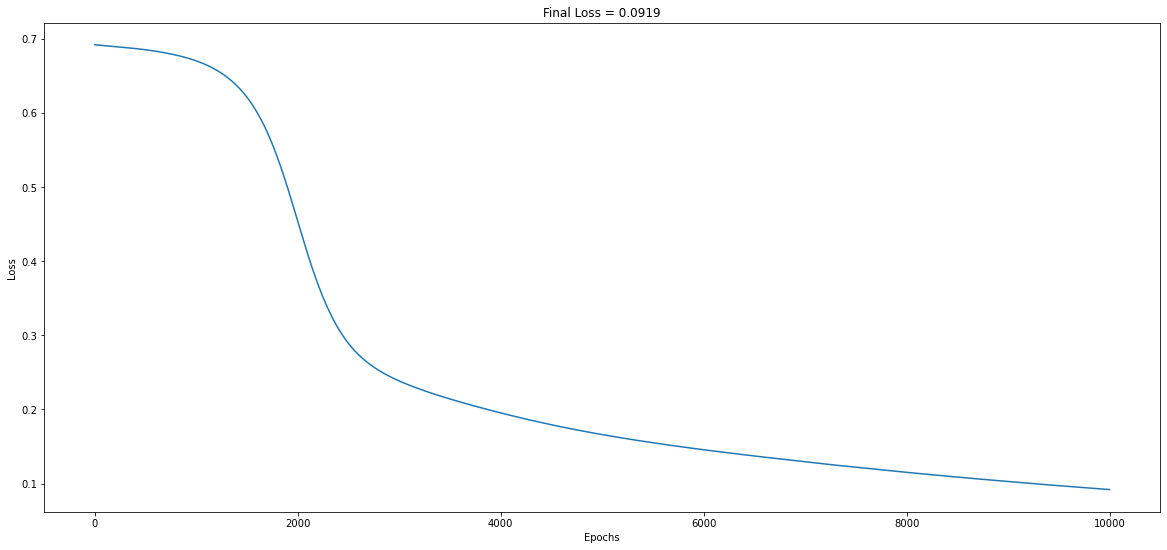

In [45]:
model, optimizer = create_model(n_input=len(cols_X), n_output=len(cols_y), lr=.01)
history = train_model(X=train_data, y=train_labels, model=model, loss_func=nn.BCELoss(), optimizer=optimizer, n_epochs=10000, plot_loss=True)

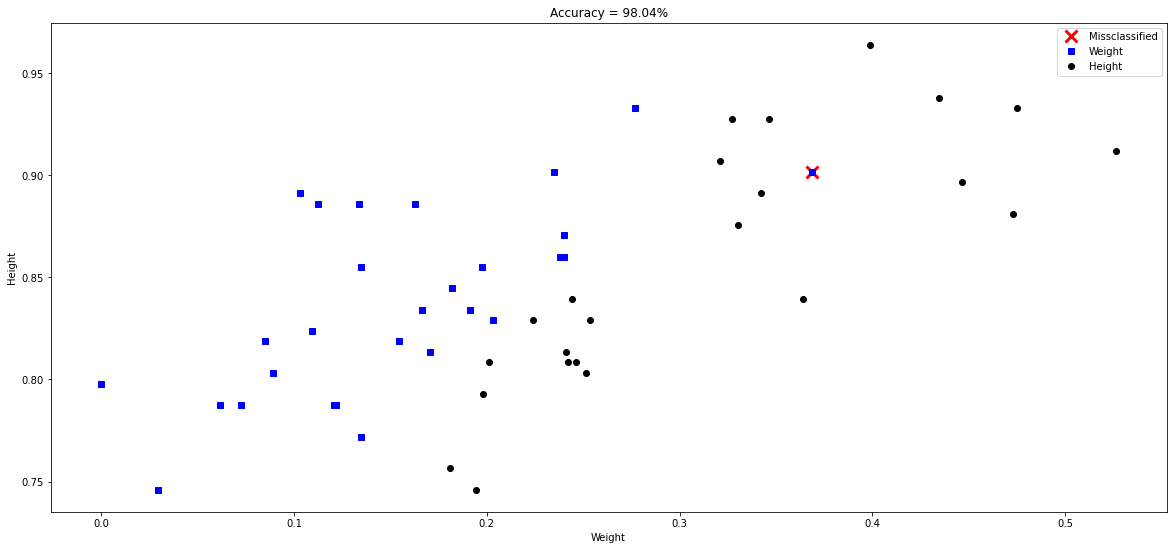

Test Accuracy: 98.04%


In [46]:
acc, pred = evaluate_model(X=test_data, y=test_labels, model=model, label_names=cols_X)
print(f"Test Accuracy: {acc:.2f}%")